In [80]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np
import uproot
import os
import glob
import awkward as ak
from scipy.stats import norm
from matplotlib.ticker import MultipleLocator


In [81]:
setup_path ="/home/haue/repositories/Masters/setup/" 
data_path = "/home/haue/repositories/Masters/data/singleprotons/Al/inclbetacut/"
twop_path = "/home/haue/repositories/Masters/data/twoproton/Al/"
Al_files = glob.glob(os.path.join(data_path, "*mlio.root"))
twop_files = glob.glob(os.path.join(twop_path, "*mlio.root"))


frac = 0.9542011788469517 # (Na21/(p+Na21)) amount of energy the daughter nucleus gets of the total energy released in the decay
frac_err = 1.032071836027589e-10 # uncertainty of the fraction
psep = 5.50410 # proton separation energy of 22Mg
psep_err = 0.00016 # error of proton separation energy of 22Mg
bw = 0.02 # bin width to be used, 10 keV
scale = 3.326542500626603 # difference in solid angle coverage of two proton events up to 4pi
difference_in_method_error = 0.002 # 2 keV - error estimated from the choice of gauss fitting instead of peak finding using SearchHighRes()

In [82]:
E2 = np.array([]); fEdep = np.array([]); bEdep=np.array([])
for batch in uproot.iterate(Al_files, expressions=["E", "fEdep", "bEdep"],
                            cut="(id==3)"):
    E2=np.append(E2, ak.flatten(batch.E))
    fEdep=np.append(fEdep, ak.flatten(batch.fEdep))
    bEdep=np.append(bEdep, ak.flatten(batch.bEdep))
E2p = np.array([])
for batch in uproot.iterate(twop_files, expressions=["E"],
                            cut="(id==3)"):
    E2p=np.append(E2p, ak.flatten(batch.E))
bins = np.arange(1000, 9000+20, 20)
counts_E2, _ = np.histogram(E2, bins=bins)
counts_E2p, _ = np.histogram(E2p, bins=bins)

Es = counts_E2 - scale * counts_E2p
Es = np.maximum(Es, 0) 
E = np.repeat((bins[:-1] + 0.5 * (bins[1] - bins[0])),np.asarray(Es).astype(int))


In [218]:

def cal_error(energy):
    betacut=1000
    Elin = np.arange(0., 11000., 10.)
    sac = np.array([])
    SA = np.loadtxt("../twoproton/sam_21al_U4.dat")
    v, fEdepmax, Elow, Eupp, fEdeplow, Esplow = np.loadtxt("../twoproton/tdz_21al_U4.dat", unpack=True)
    for i in range(len(Elin)):
        val = 0.
        if Elin[i] < betacut:
    #            print(Elin[i])
            sac = np.append(sac, val)
        else:
                # do not include outermost strips
            for j in range(0+1, 16-1):
                for k in range(0+1, 16-1):
                    if Esplow[j*16 + k] < Elin[i] and Elin[i] < Eupp[j*16 + k]:
    #                         print(j, k, Elin[i])
                        pass
                    else:
                        val += SA[j, k]
            sac = np.append(sac, val)
    sac_ = 100*sac/(4*np.pi)
    sacmask = np.where(sac_<np.max(sac_))
    bad_E = Elin[sacmask]
    Emask = (bad_E>betacut)
    bad_E = bad_E[Emask]
    if energy>np.min(bad_E):
        raise ValueError(f"The energy in question falls within telescope deadzone no error correction to be deduced -> try energies above the zone: {np.max(bad_E)} using pcal_error(fEdep,bEdep)")
    hh = np.loadtxt("U4calerrors.dat") # first 16 entries are the errors from the front side strips in rising order and the last 16 are the backside strips in rising order
    front_err = hh[:len(hh)//2]
    back_err = hh[len(hh)//2:] 

    SA = np.loadtxt("../twoproton/sam_21al_U4.dat") # first entry is front strip 1 and is equal to zero next entry is front strip 2 
    
    cals = np.loadtxt(setup_path+"U4EE.cal")
    front_cal = cals[:len(hh)//2]
    back_cal = cals[len(hh)//2:]
    
    maxSA = np.max(SA)
    total_variance = 0
    counter = 0
    for i in range(16):
        for j in range(16):
            if i==0 or i==15 or j==0 or j==15:
                continue
            
            uncal_x = (2*energy - (front_cal[i][0]+back_cal[j][0])) / (front_cal[i][1]+back_cal[j][1])
            
            variance = (0.5 * front_err[i][0])**2 + \
                            (uncal_x/2 * front_err[i][1])**2 + \
                            (0.5 * back_err[j][0])**2 + \
                            (uncal_x/2 * back_err[j][1])**2 + \
                            (0.5 * uncal_x * front_err[i][2]) + \
                            (0.5 * uncal_x * back_err[j][2])
            weighted_variance = variance*(SA[i][j]/maxSA)
            total_variance += weighted_variance
            
            counter+=1
    
    return np.sqrt(total_variance/counter)/1e3





def pcal_error(fedep,bedep):
    betacut = 1000
    Elin = np.arange(0., 11000., 10.)
    sac = np.array([])
    SA = np.loadtxt("../twoproton/sam_21al_U4.dat")
    v, fEdepmax, Elow, Eupp, fEdeplow, Esplow = np.loadtxt("../twoproton/tdz_21al_U4.dat", unpack=True)
    for i in range(len(Elin)):
        val = 0.
        if Elin[i] < betacut:
    #            print(Elin[i])
            sac = np.append(sac, val)
        else:
                # do not include outermost strips
            for j in range(0+1, 16-1):
                for k in range(0+1, 16-1):
                    if Esplow[j*16 + k] < Elin[i] and Elin[i] < Eupp[j*16 + k]:
    #                         print(j, k, Elin[i])
                        pass
                    else:
                        val += SA[j, k]
            sac = np.append(sac, val)
    sac_ = 100*sac/(4*np.pi)
    sacmask = np.where(sac_<np.max(sac_))
    bad_E = Elin[sacmask]
    if fedep+bedep < np.min(bad_E)*0.95:
        #print(np.max(bad_E))
        raise ValueError(f"The energy in question falls below the telescope energy region -> try energies above the zone: {np.min(bad_E)} using pcal_error(fEdep,bEdep)")
    hh = np.loadtxt("U4calerrors.dat") # first 16 entries are the errors from the front side strips in rising order and the last 16 are the backside strips in rising order
    front_err = hh[:len(hh)//2]
    back_err = hh[len(hh)//2:] 

    SA = np.loadtxt("../twoproton/sam_21al_U4.dat") # first entry is front strip 1 and is equal to zero next entry is front strip 2 
    padcal_errs = np.loadtxt("P4calerrors.dat")
    padcal = np.loadtxt(setup_path+"P4mult.cal")
    cals = np.loadtxt(setup_path+"U4EE.cal")
    front_cal = cals[:len(hh)//2]
    back_cal = cals[len(hh)//2:]
    
    maxSA = np.max(SA)
    total_variance = 0
    counter = 0
    for i in range(16):
        for j in range(16):
            if i==0 or i==15 or j==0 or j==15:
                continue
            
            uncal_fedep = (2*fedep - (front_cal[i][0]+back_cal[j][0])) / (front_cal[i][1]+back_cal[j][1])
            
            variance = (0.5 * front_err[i][0])**2 + \
                            (uncal_fedep/2 * front_err[i][1])**2 + \
                            (0.5 * back_err[j][0])**2 + \
                            (uncal_fedep/2 * back_err[j][1])**2 + \
                            (0.5 * uncal_fedep * front_err[i][2]) + \
                            (0.5 * uncal_fedep * back_err[j][2])
            weighted_variance = variance*(SA[i][j]/maxSA)
            total_variance += weighted_variance
            
            counter+=1
    uncal_bedep = (bedep-padcal[0])/padcal[1]
    pad_var = (uncal_bedep**2 * padcal_errs[1]**2)+padcal_errs[0]**2
    return np.sqrt(total_variance/counter+pad_var)/1e3



def counter(ax,E, x_low, x_up, quiet=False):#, yscale='linear'):
    ys, xs = np.histogram(E/1e3, bins=np.arange(x_low,x_up+bw,bw))
    counts = np.sum(ys)
    counts_err = np.sqrt(np.sum(ys))
    if not quiet:
        #plt.figure(figsize=(8,5))
        #plt.hist(E/1e3, bins=np.arange(x_low-0.5,x_up+0.5+bw,bw), histtype='step', color='k', label="Full Data")
        ax.hist(E/1e3, bins=np.arange(x_low, x_up+bw,bw), histtype='step', color='r', label="Fit region")
        #plt.yscale(yscale)
        #plt.legend()
        #plt.xlabel("Energy(MeV)")
        #plt.ylabel("Counts/10keV")
        #plt.title(f"Counted region: {x_low}-{x_up}")
    return counts, counts_err


def draw_arrow_at_energy(ax, energy, counts, bins, label):
    energy_MeV = energy / 1e3
    bin_idx = np.searchsorted(bins, energy_MeV) - 1
    if bin_idx < 0 or bin_idx >= len(counts):
        raise ValueError(f"Energy {energy} keV is out of histogram range.")
    bin_width = bins[1] - bins[0]
    bin_left = bins[bin_idx]
    bin_right = bins[bin_idx + 1]
    relative_pos = (energy_MeV - bin_left) / bin_width
    if 0.25 < relative_pos < 0.75 or bin_idx == len(counts) - 1:
        max_count = counts[bin_idx]
        avg_energy = 0.5 * (bin_left + bin_right)
    else:
        if bin_idx + 1 >= len(counts):
            raise ValueError("Cannot average beyond last bin.")
        max_count = max(counts[bin_idx], counts[bin_idx + 1])
        avg_energy = 0.5 * (bins[bin_idx] + bins[bin_idx + 2])
    ax.annotate('', xy=(avg_energy, max_count + max_count*0.1), xytext=(avg_energy, max_count + max_count*0.2), arrowprops=dict(facecolor='red', edgecolor='red', arrowstyle='->'))
    ax.text(avg_energy, max_count + max_count*0.25, label, ha='center', va='bottom', color='red', fontsize=12)
    return int(avg_energy * 1e3)




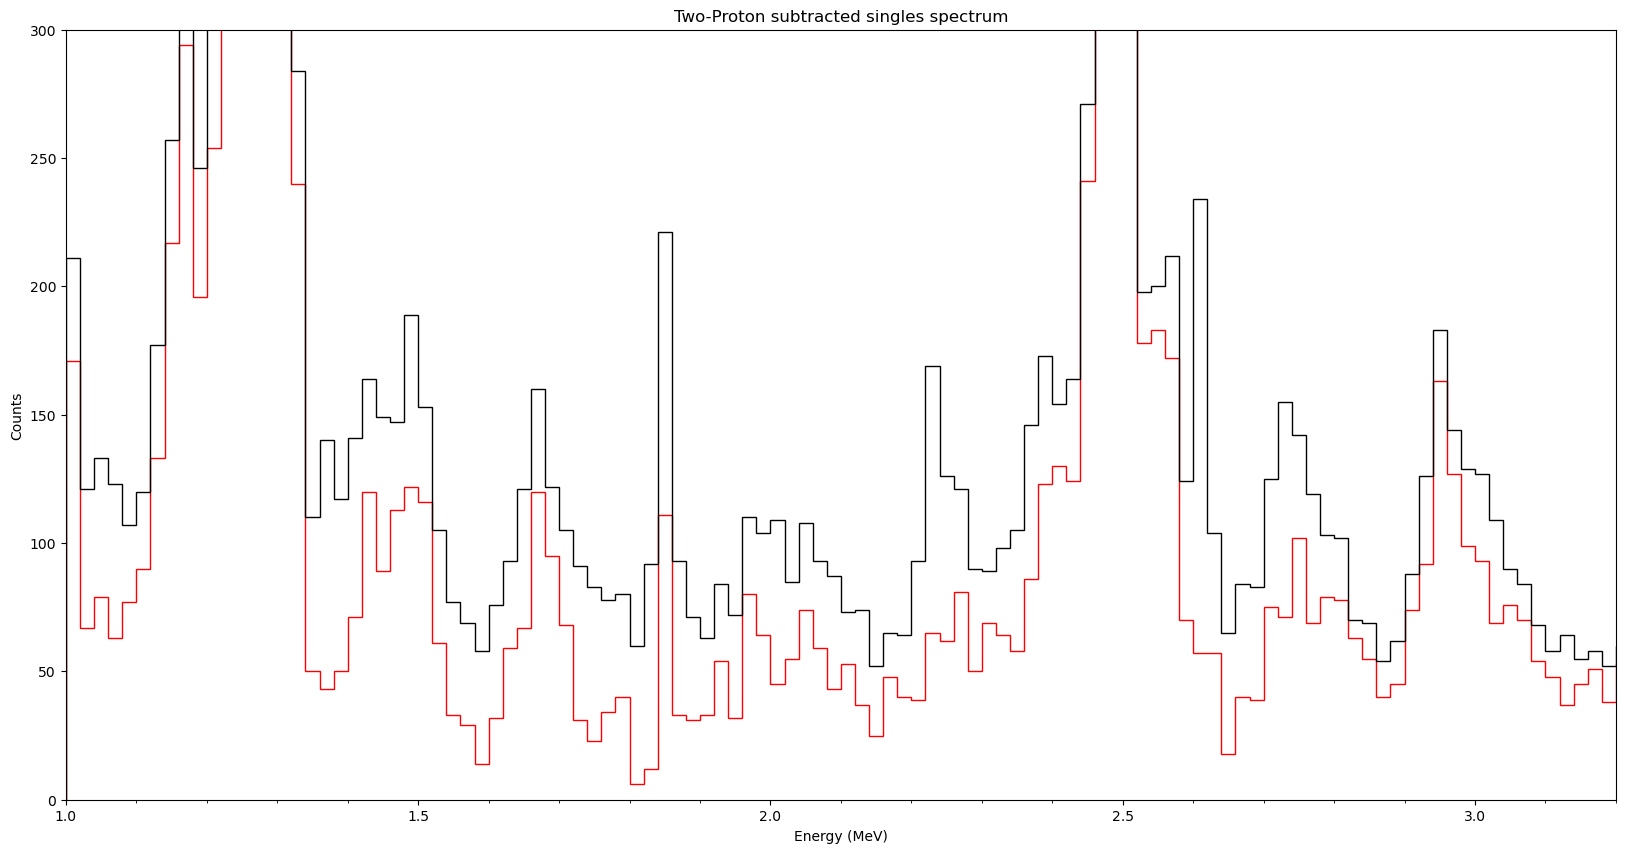

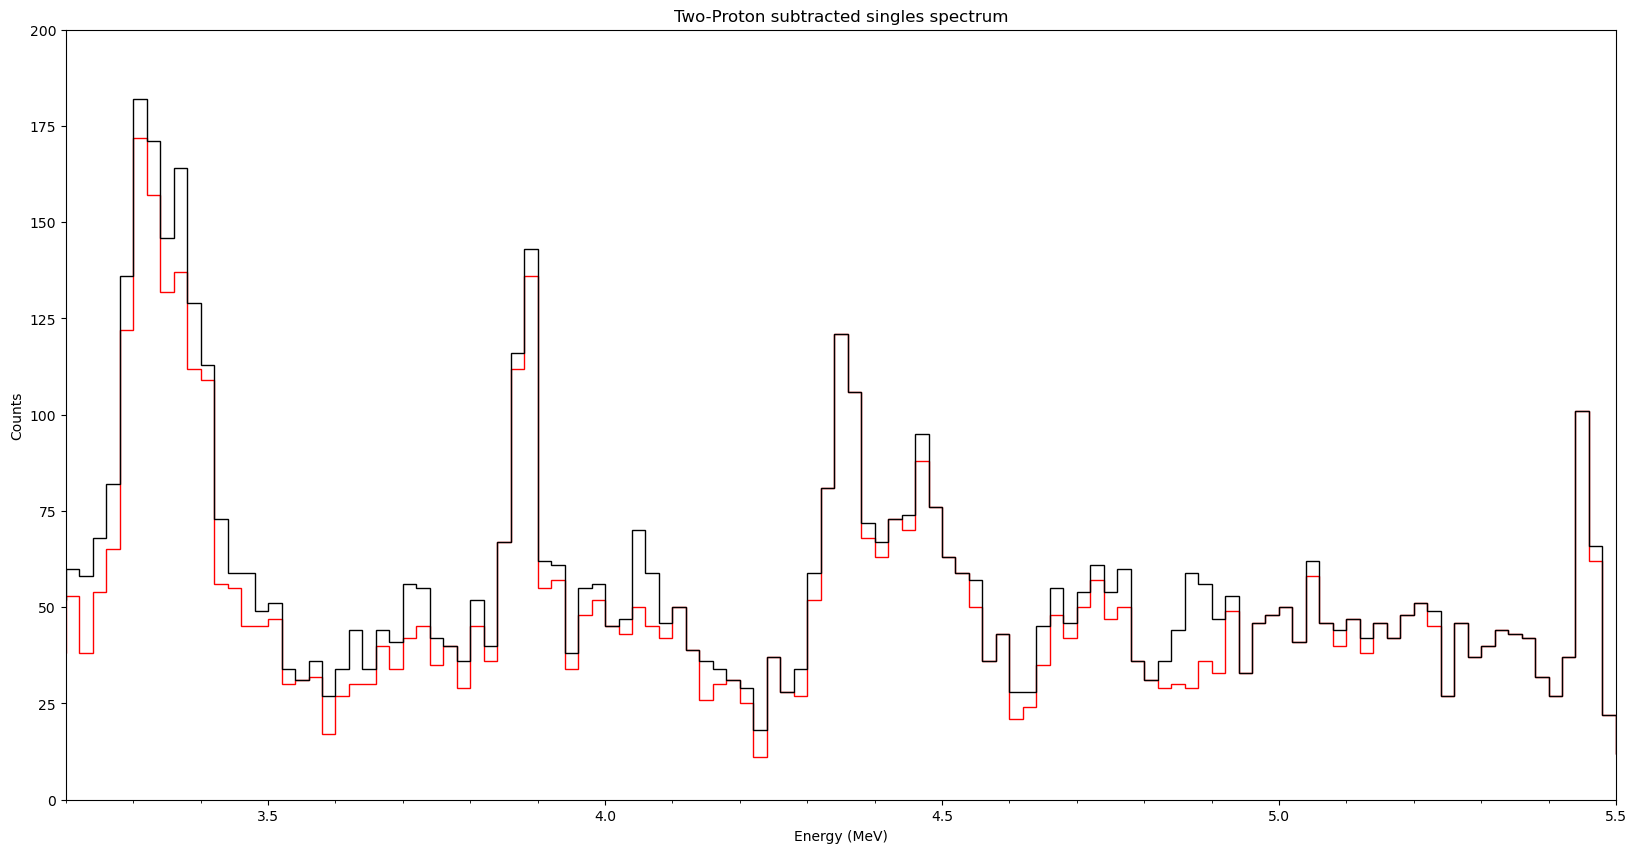

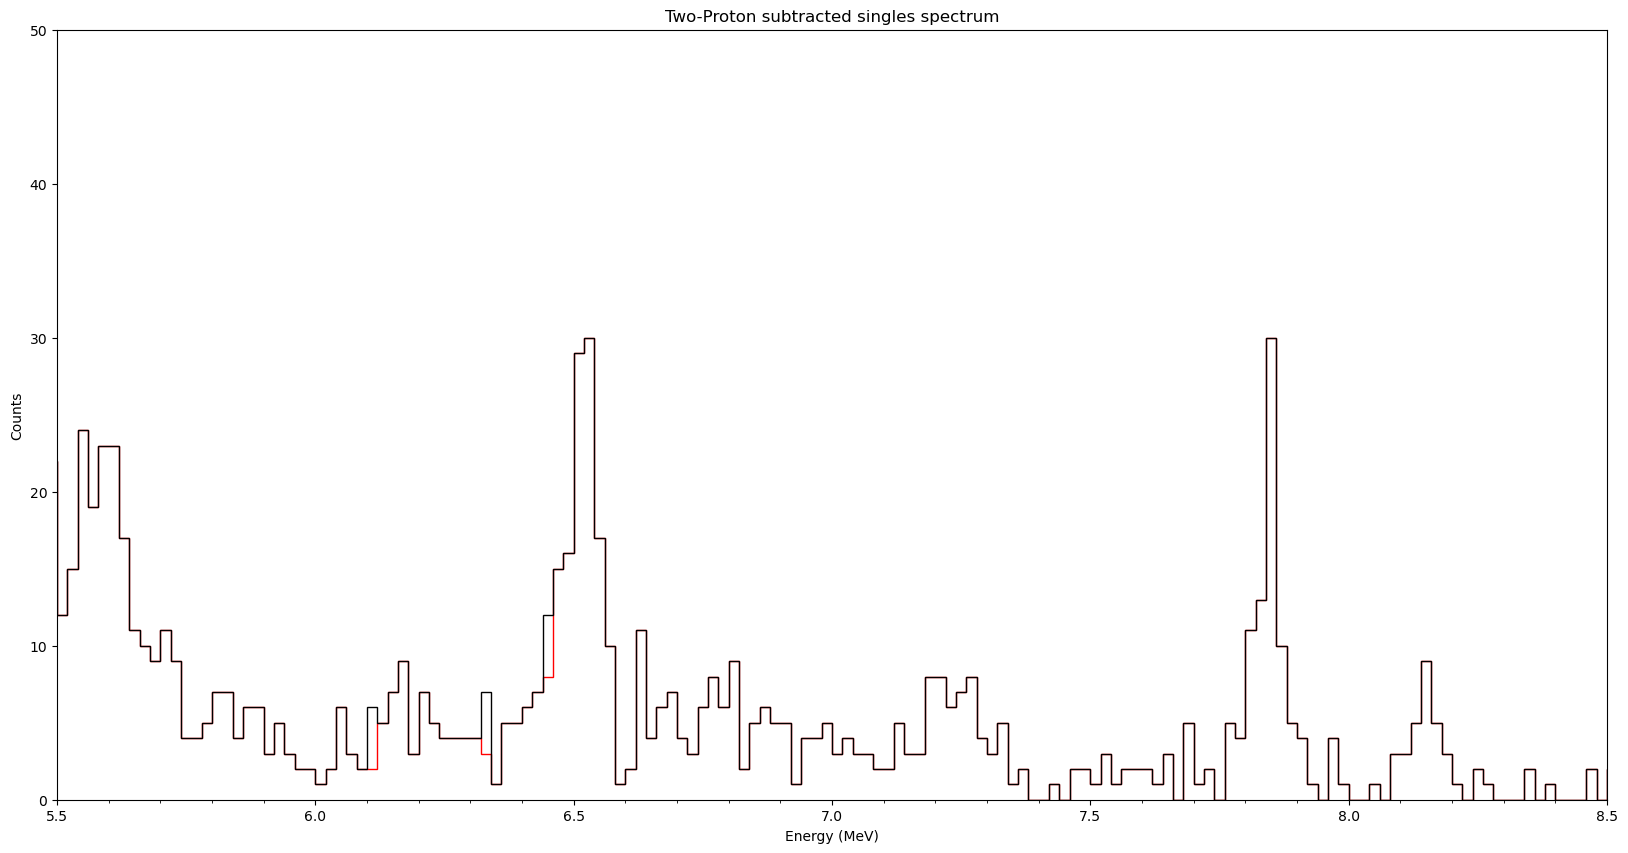

In [258]:

bins = np.arange(1, 9 + bw, bw)


plt.figure(figsize=(20,10))
plt.hist(E/1e3, bins=bins, histtype='step', color='r')
plt.hist(E2/1e3, bins=bins, histtype='step', color='k')

plt.xlabel('Energy (MeV)')
plt.ylabel('Counts')
plt.title('Two-Proton subtracted singles spectrum')
#plt.legend()
#plt.yscale('log')
plt.xlim(0.5,9)
plt.ylim(0,300)
plt.xlim(1,3.2)
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))

plt.figure(figsize=(20,10))
plt.hist(E/1e3, bins=bins, histtype='step', color='r')
plt.hist(E2/1e3, bins=bins, histtype='step', color='k')

plt.xlabel('Energy (MeV)')
plt.ylabel('Counts')
plt.title('Two-Proton subtracted singles spectrum')
#plt.legend()
#plt.yscale('log')
plt.xlim(0.5,9)
plt.ylim(0,200)
plt.xlim(3.2,5.5)
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
plt.figure(figsize=(20,10))
plt.hist(E/1e3, bins=bins, histtype='step', color='r')
plt.hist(E2/1e3, bins=bins, histtype='step', color='k')

plt.xlabel('Energy (MeV)')
plt.ylabel('Counts')
plt.title('Two-Proton subtracted singles spectrum')
#plt.legend()
#plt.yscale('log')
plt.xlim(0.5,9)
plt.ylim(0,50)
plt.xlim(5.5,8.5)
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))

[1430 1490 1670 1790 1850 1970 2050 2250 2750 2950 3050]
Peak #:  Counts and error:   Branching ratio and error
peak1:     286 (16)          br: 2.57(0.15)
peak2:     518 (22)          br: 4.66(0.21)
peak3:     509 (23)          br: 4.58(0.22)
peak4:     80 (9)            br: 0.72(0.08)
peak5:     156 (12)          br: 1.40(0.11)
peak5:     316 (17)          br: 2.85(0.16)
peak6:     368 (19)          br: 3.31(0.18)
peak9:     356 (19)          br: 3.20(0.18)
peak10:    315 (18)          br: 2.83(0.17)
peak11:    1010 (32)         br: 9.98(0.34)
peak11:    46 (14)           br: 0.41(0.13)


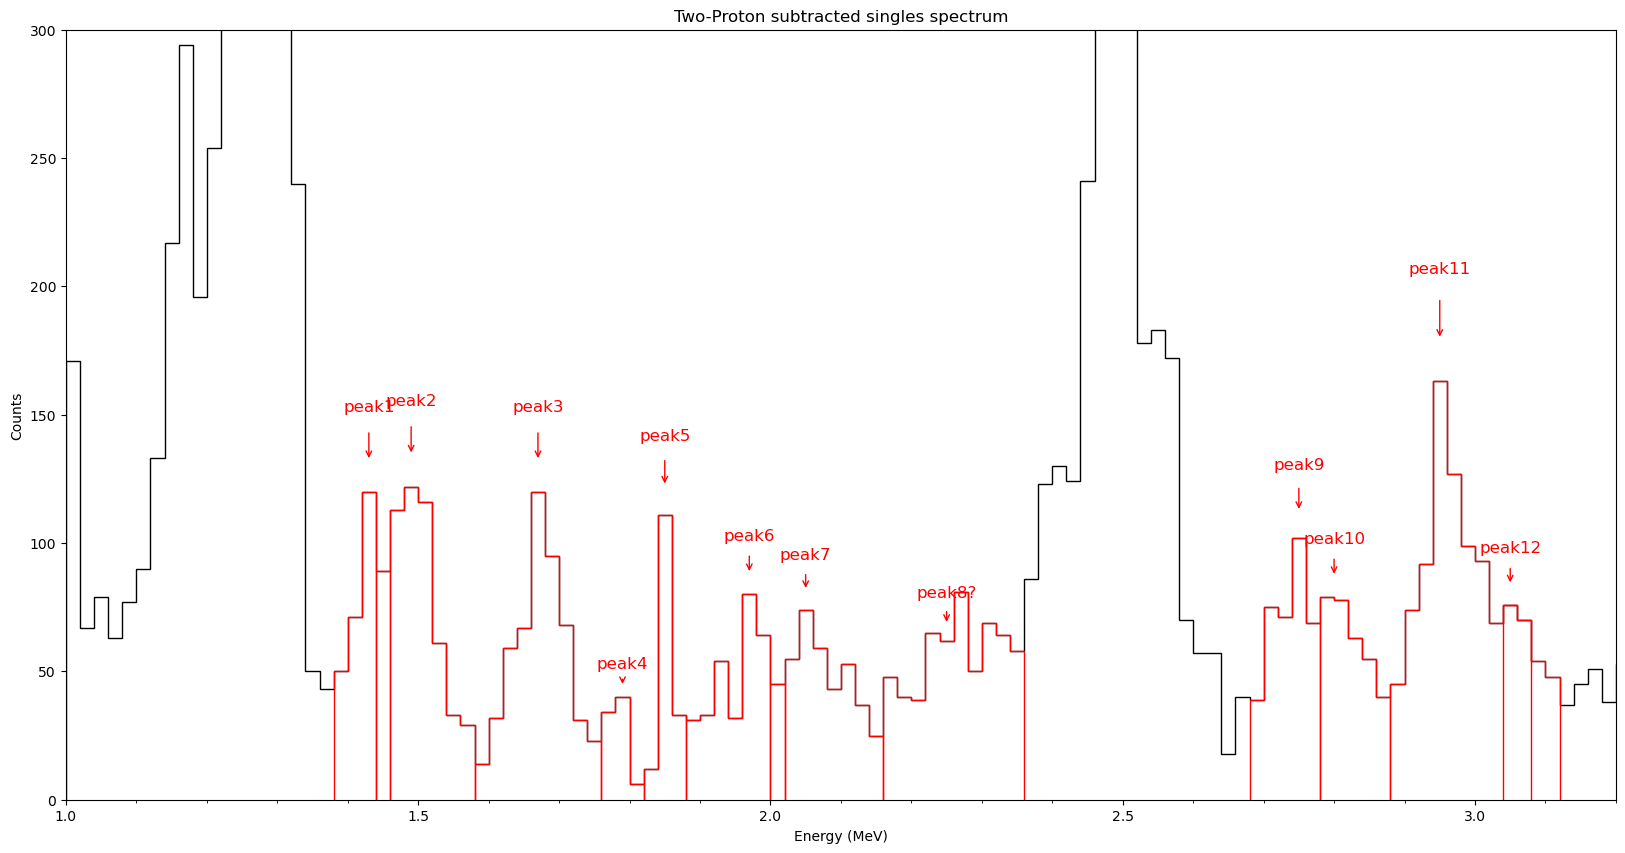

In [219]:
plt.figure(figsize=(20,10))
plt.hist(E/1e3, bins=bins, histtype='step', color='k')
#plt.hist(E2/1e3, bins=bins, histtype='step', color='k')
counts, _ = np.histogram(E/1e3, bins=bins)
plt.xlabel('Energy (MeV)')
plt.ylabel('Counts')
plt.title('Two-Proton subtracted singles spectrum')
#plt.legend()
#plt.yscale('log')
plt.xlim(0.5,9)
plt.ylim(0,300)
plt.xlim(1,3.2)
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
one = draw_arrow_at_energy(ax, energy=1435, counts=counts, bins=bins, label="peak1")
two = draw_arrow_at_energy(ax, energy=1490, counts=counts, bins=bins, label="peak2")
three = draw_arrow_at_energy(ax, energy=1670, counts=counts, bins=bins, label="peak3")
four = draw_arrow_at_energy(ax, energy=1850, counts=counts, bins=bins, label="peak5")
five = draw_arrow_at_energy(ax, energy=1790, counts=counts, bins=bins, label="peak4")
six = draw_arrow_at_energy(ax, energy=1975, counts=counts, bins=bins, label="peak6")
eight = draw_arrow_at_energy(ax, energy=2250, counts=counts, bins=bins, label="peak8?")
seven = draw_arrow_at_energy(ax, energy=2050, counts=counts, bins=bins, label="peak7")
nine = draw_arrow_at_energy(ax, energy=2750, counts=counts, bins=bins, label="peak9")
ten = draw_arrow_at_energy(ax, energy=2950, counts=counts, bins=bins, label="peak11")
eleven = draw_arrow_at_energy(ax, energy=3050, counts=counts, bins=bins, label="peak12")
twelve = draw_arrow_at_energy(ax, energy=2800, counts=counts, bins=bins, label="peak10")
#six = draw_arrow_at_energy(ax, energy=2250, counts=counts, bins=bins)
print(np.sort(np.array([one,two,three,four,five,six,seven,eight, nine,ten,eleven])))

totc = 11122
totc_e = 186
def rel(c, c_e):
    br = (c/totc) *100
    br_e = br*np.sqrt((c_e/c)**2+(totc_e/totc)**2)
    return br,br_e
print("Peak #:  Counts and error:   Branching ratio and error")
print("="*70)
c11, c11_e = counter(ax,E,1.38, 1.42)
c12, c12_e = counter(ax,E,1.46, 1.56)
c13, c13_e = counter(ax,E,1.44,1.44)
cp1 = c11+c13/2; cp1_e = np.sqrt(c11_e**2 + (0.5 * c13_e)**2)
cp2 = c12+c13/2; cp2_e = np.sqrt(c12_e**2 + (0.5 * c13_e)**2)
br11, br11_e = rel(cp1,cp1_e)
br12, br12_e = rel(cp2,cp2_e) 
print("peak1:    ",np.round(cp1).astype(int),f"({cp1_e:.0f})         ", f"br: {br11:.2f}({br11_e:.2f})")
print("peak2:    ",np.round(cp2).astype(int),f"({cp2_e:.0f})         ", f"br: {br12:.2f}({br12_e:.2f})")

c2, c2_e = counter(ax,E,1.58, 1.76)
br2, br2_e = rel(c2,c2_e)
print("peak3:    ",np.round(c2.astype(int)), f"({c2_e:.0f})         ", f"br: {br2:.2f}({br2_e:.2f})")

c3, c3_e = counter(ax,E,1.76, 1.80) 
br3, br3_e = rel(c3,c3_e)
print("peak4:    ",np.round(c3.astype(int)), f"({c3_e:.0f})           ", f"br: {br3:.2f}({br3_e:.2f})")
c4, c4_e = counter(ax,E,1.82, 1.86)
br4, br4_e = rel(c4,c4_e)
print("peak5:    ",np.round(c4.astype(int)), f"({c4_e:.0f})         ", f"br: {br4:.2f}({br4_e:.2f})")

c51, c51_e = counter(ax,E,1.88, 1.98) 
c52, c52_e = counter(ax,E,2.02, 2.14)
c53, c53_e = counter(ax,E,2.0,2.0)
cp5 = c51+c53/2; cp5_e = np.sqrt(c51_e**2 + (0.5 * c53_e)**2)
cp6 = c52+c53/2; cp6_e = np.sqrt(c52_e**2 + (0.5 * c53_e)**2)
br51, br51_e = rel(cp5,cp5_e)
br52, br52_e = rel(cp6,cp6_e) 
print("peak5:    ",np.round(cp5).astype(int),f"({cp5_e:.0f})         ", f"br: {br51:.2f}({br51_e:.2f})")
print("peak6:    ",np.round(cp6).astype(int),f"({cp6_e:.0f})         ", f"br: {br52:.2f}({br52_e:.2f})")

c6, c6_e = counter(ax,E,2.16, 2.36) 


c71, c71_e = counter(ax,E,2.68, 2.78) 
c72, c72_e = counter(ax,E,2.78, 2.86) 
br71, br71_e = rel(c71,c71_e)
br72, br72_e = rel(c72,c72_e) 
print("peak9:    ",np.round(c71).astype(int),f"({c71_e:.0f})         ", f"br: {br71:.2f}({br71_e:.2f})")
print("peak10:   ",np.round(c72).astype(int),f"({c72_e:.0f})         ", f"br: {br72:.2f}({br72_e:.2f})")


c8, c8_e = counter(ax,E,2.88, 3.10)
 
c82, c82_e = counter(ax,E,3.04, 3.06)
c82 = c82-2*50; c82_e = np.sqrt(c82_e**2+50)
br8, br8_e = rel(c8+2*50,np.sqrt(c8_e**2+50))
br82, br82_e = rel(c82,c82_e)
print("peak11:   ",np.round(c8).astype(int),f"({c8_e:.0f})        ", f"br: {br8:.2f}({br8_e:.2f})")
print("peak11:   ",np.round(c82).astype(int),f"({c82_e:.0f})          ", f"br: {br82:.2f}({br82_e:.2f})")


[3310 3380 3410 3450 3890 3990 4120 4350 4430 4470 4590 5450]
peak13:     1144 (37)         br: 10.29(0.37)
peak14:     50 (7)            br: 0.45(0.06)
peak15:     30 (5)            br: 0.27(0.05)
peak16:     30 (5)            br: 0.27(0.05)
peak17:     542 (23)          br: 4.87(0.22)
peak18:     145 (12)          br: 1.30(0.11)
peak19:     131 (11)          br: 1.18(0.10)
peak20:     500 (22)          br: 4.50(0.21)
peak21:     45 (4)            br: 0.41(0.04)
peak22:     509 (22)          br: 4.57(0.21)
peak23:     43 (5)            br: 0.38(0.05)


5300

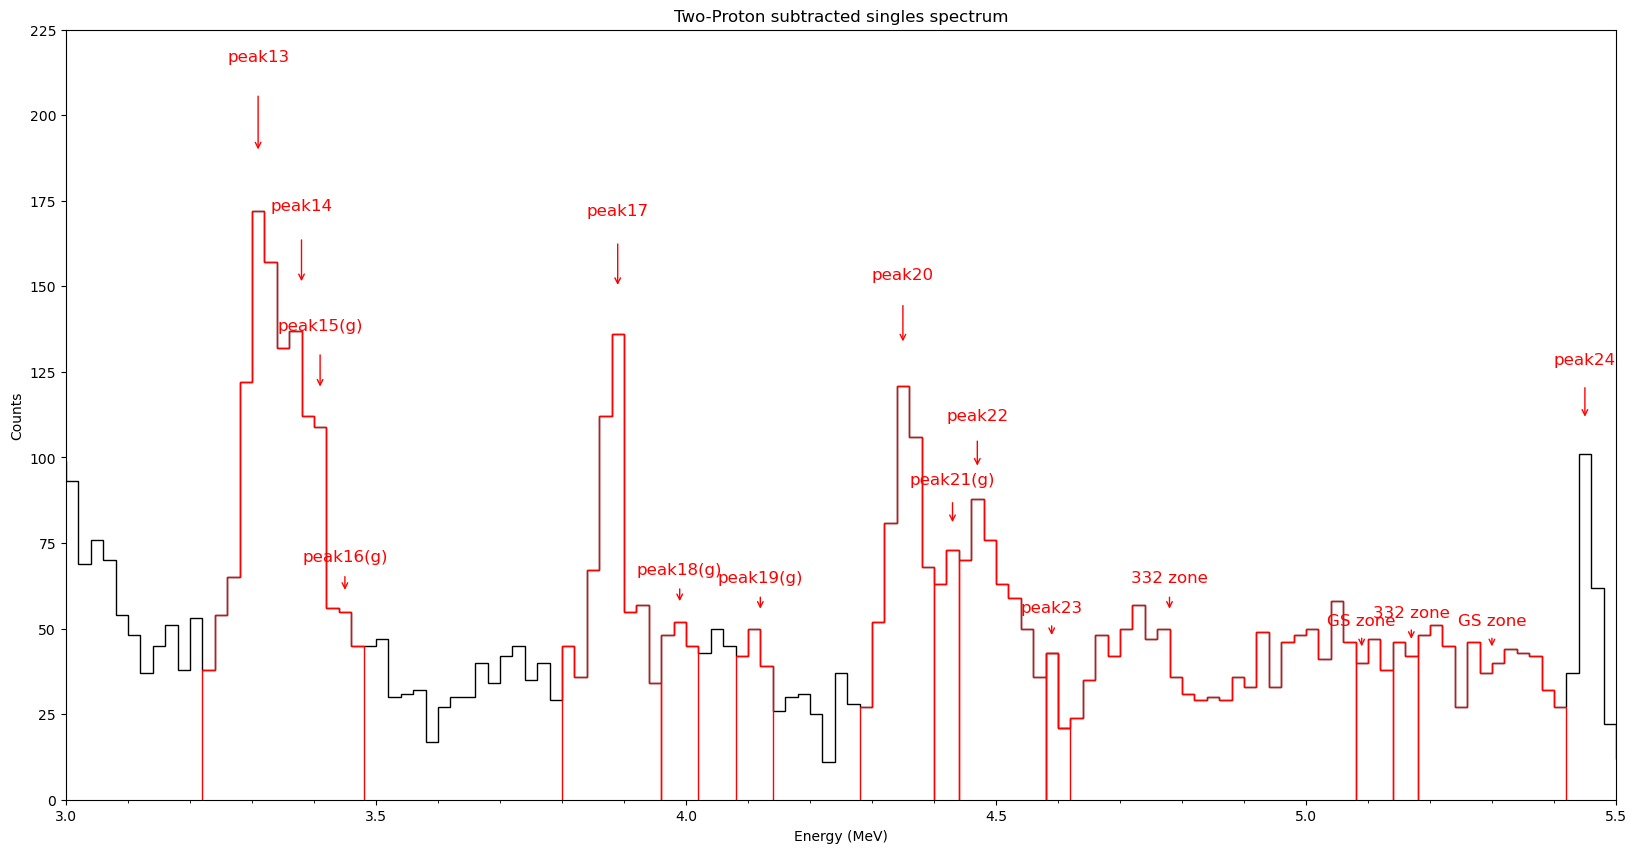

In [250]:
plt.figure(figsize=(20,10))
plt.hist(E/1e3, bins=bins, histtype='step', color='k')
#plt.hist(E2/1e3, bins=bins, histtype='step', color='k')
counts, _ = np.histogram(E/1e3, bins=bins)
plt.xlabel('Energy (MeV)')
plt.ylabel('Counts')
plt.title('Two-Proton subtracted singles spectrum')
#plt.legend()

#plt.yscale('log')
plt.ylim(0,225)
plt.xlim(3,5.5)
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
one = draw_arrow_at_energy(ax, energy=3310, counts=counts, bins=bins, label="peak13")
two = draw_arrow_at_energy(ax, energy=3380, counts=counts, bins=bins, label="peak14")
three = draw_arrow_at_energy(ax, energy=3890, counts=counts, bins=bins, label="peak17")
four = draw_arrow_at_energy(ax, energy=4350, counts=counts, bins=bins, label="peak20")
five = draw_arrow_at_energy(ax, energy=4430, counts=counts, bins=bins, label="peak21(g)")
six = draw_arrow_at_energy(ax, energy=4470, counts=counts, bins=bins, label="peak22")
eight = draw_arrow_at_energy(ax, energy=4590, counts=counts, bins=bins, label="peak23")
seven = draw_arrow_at_energy(ax, energy=5450, counts=counts, bins=bins, label="peak24")
nine = draw_arrow_at_energy(ax, energy=3450, counts=counts, bins=bins, label="peak16(g)")
ten = draw_arrow_at_energy(ax, energy=3990, counts=counts, bins=bins, label="peak18(g)")
eleven = draw_arrow_at_energy(ax, energy=4120, counts=counts, bins=bins, label="peak19(g)")
twelve = draw_arrow_at_energy(ax, energy=3410, counts=counts, bins=bins, label="peak15(g)")
#six = draw_arrow_at_energy(ax, energy=2250, counts=counts, bins=bins)
print(np.sort(np.array([one,two,three,four,five,six,seven,eight, nine, ten, eleven,twelve])))

c13, c13_e = counter(ax,E,3.22, 3.48)
c131 = c13-50-30-30; c131_e = np.sqrt(c13_e**2+50+30+30)
c132 = 50; c132_e = np.sqrt(50)
c133 = 30; c133_e = np.sqrt(30)
c134 = 30; c134_e = np.sqrt(30)

br131, br131_e = rel(c131,c131_e)
br132, br132_e = rel(c132,c132_e)
br133, br133_e = rel(c133,c133_e)
br134, br134_e = rel(c134,c134_e)
print("peak13:    ",np.round(c131).astype(int),f"({c131_e:.0f})        ", f"br: {br131:.2f}({br131_e:.2f})")
print("peak14:    ",np.round(c132).astype(int),f"({c132_e:.0f})           ", f"br: {br132:.2f}({br132_e:.2f})")
print("peak15:    ",np.round(c133).astype(int),f"({c133_e:.0f})           ", f"br: {br133:.2f}({br133_e:.2f})")
print("peak16:    ",np.round(c134).astype(int),f"({c134_e:.0f})           ", f"br: {br134:.2f}({br134_e:.2f})")



c17, c17_e = counter(ax,E,3.8, 3.94)
br17, br17_e = rel(c17,c17_e)
print("peak17:    ",np.round(c17).astype(int),f"({c17_e:.0f})         ", f"br: {br17:.2f}({br17_e:.2f})")

c18, c18_e = counter(ax,E,3.96, 4.02)
br18, br18_e = rel(c18,c18_e)
print("peak18:    ",np.round(c18).astype(int),f"({c18_e:.0f})         ", f"br: {br18:.2f}({br18_e:.2f})")
c19, c19_e = counter(ax,E,4.08, 4.14)
br19, br19_e = rel(c19,c19_e)
print("peak19:    ",np.round(c19).astype(int),f"({c19_e:.0f})         ", f"br: {br19:.2f}({br19_e:.2f})")



c202, c202_e = counter(ax,E,4.4, 4.44) # 1/3 belongs to this peak and the remaining is split into the other 1/3 parts and given to the neighboring peaks
cp202 = c202*1/3; cp202_e = c202_e*1/3
br21, br21_e = rel(cp202,cp202_e)


c204, c204_e = counter(ax,E,4.58, 4.62) #1/3 of this peak is a part of the neighboring peak
cp204 = c204*2/3; cp204_e = c204_e*2/3
br23, br23_e = rel(cp204,cp204_e)


c201, c201_e = counter(ax,E,4.28, 4.4)
cp201 = c201+cp202; cp201_e = np.sqrt(c201_e**2+cp202_e**2)
br20, br20_e = rel(cp201,cp201_e)


c203, c203_e = counter(ax,E,4.44, 4.58)
cp203 = c203+cp202+c204*1/3; cp203_e = np.sqrt(c203_e**2+cp202_e**2+(c204_e*1/3)**2)
br22, br22_e = rel(cp203,cp203_e)

print("peak20:    ",np.round(cp201).astype(int),f"({cp201_e:.0f})         ", f"br: {br20:.2f}({br20_e:.2f})")
print("peak21:    ",np.round(cp202).astype(int),f"({cp202_e:.0f})           ", f"br: {br21:.2f}({br21_e:.2f})")
print("peak22:    ",np.round(cp203).astype(int),f"({cp203_e:.0f})         ", f"br: {br22:.2f}({br22_e:.2f})")
print("peak23:    ",np.round(cp204).astype(int),f"({cp204_e:.0f})           ", f"br: {br23:.2f}({br23_e:.2f})")



c25, c25_e = counter(ax,E,4.58, 5.08)
c25, c25_e = counter(ax,E,5.08, 5.14)
c25, c25_e = counter(ax,E,5.14, 5.18)
c25, c25_e = counter(ax,E,5.18, 5.42)
draw_arrow_at_energy(ax, energy=4780, counts=counts, bins=bins, label="332 zone")
draw_arrow_at_energy(ax, energy=5090, counts=counts, bins=bins, label="GS zone")
draw_arrow_at_energy(ax, energy=5170, counts=counts, bins=bins, label="332 zone")
draw_arrow_at_energy(ax, energy=5300, counts=counts, bins=bins, label="GS zone")

[5550 5600 6170 6530 7200 7270 7850 8150]
peak26:     60 (7)          br: 0.54(0.07)
peak27:     94 (9)          br: 0.84(0.09)
peak32:     83 (9)          br: 0.75(0.08)
peak32:     29 (5)          br: 0.26(0.05)


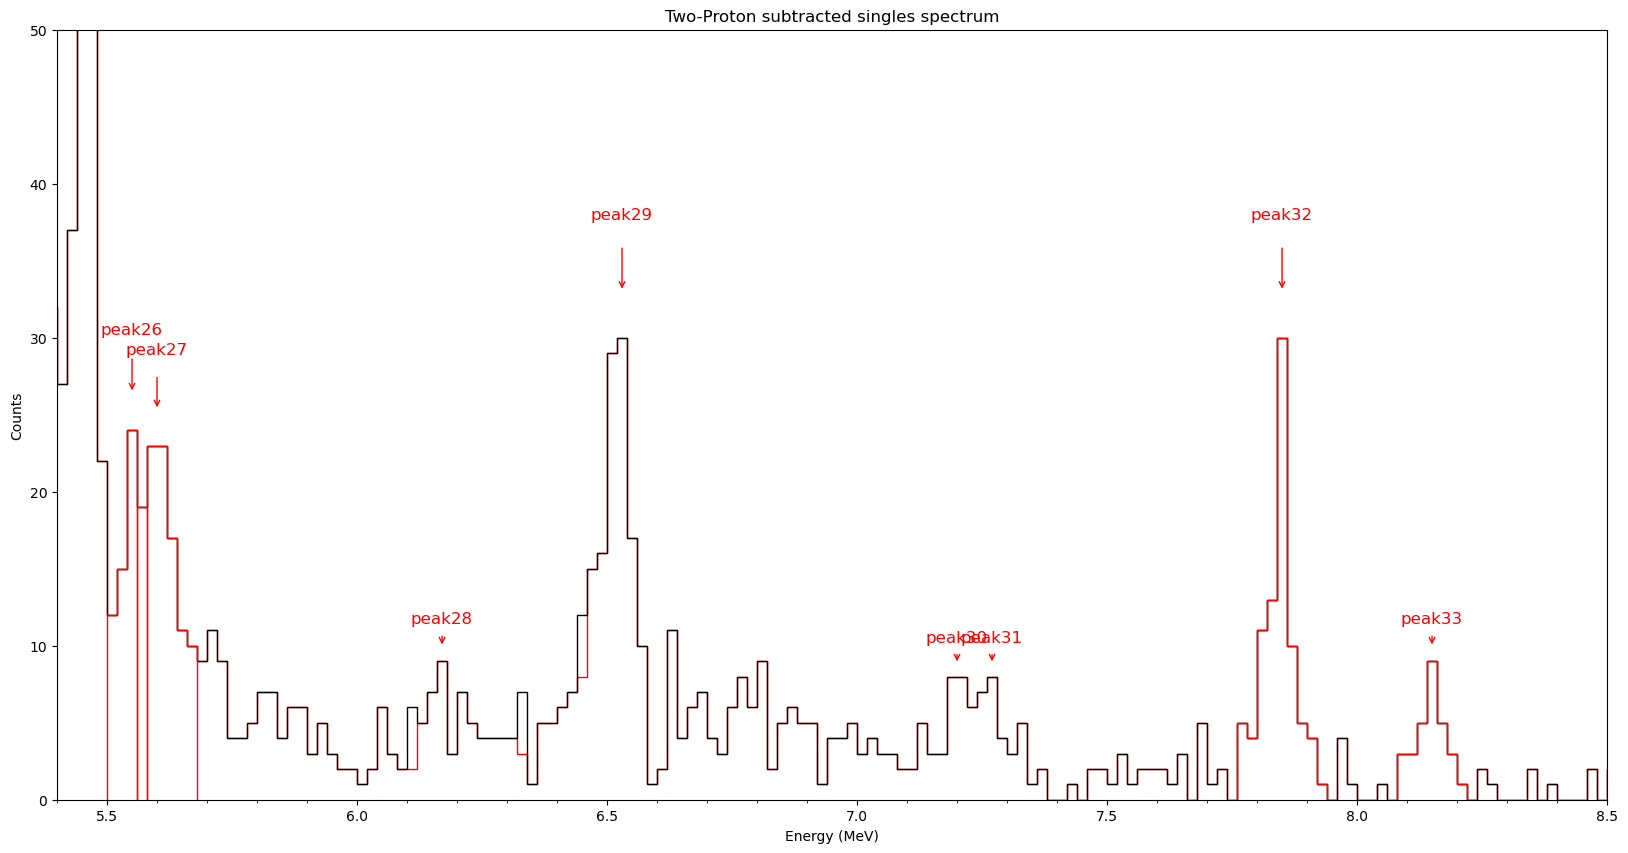

In [249]:
plt.figure(figsize=(20,10))
plt.hist(E/1e3, bins=bins, histtype='step', color='r')
plt.hist(E2/1e3, bins=bins, histtype='step', color='k')

plt.xlabel('Energy (MeV)')
plt.ylabel('Counts')
plt.title('Two-Proton subtracted singles spectrum')
#plt.yscale('log')
plt.xlim(0.5,9)
plt.ylim(0,50)
plt.xlim(5.4,8.5)
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))



one = draw_arrow_at_energy(ax, energy=5550, counts=counts, bins=bins, label="peak26")
two = draw_arrow_at_energy(ax, energy=5600, counts=counts, bins=bins, label="peak27")
three=draw_arrow_at_energy(ax, energy=6170, counts=counts, bins=bins, label="peak28")
four=draw_arrow_at_energy(ax, energy=6530, counts=counts, bins=bins, label="peak29")
five=draw_arrow_at_energy(ax, energy=7200, counts=counts, bins=bins, label="peak30")
six=draw_arrow_at_energy(ax, energy=7270, counts=counts, bins=bins, label="peak31")
seven=draw_arrow_at_energy(ax, energy=7850, counts=counts, bins=bins, label="peak32")
eight=draw_arrow_at_energy(ax, energy=8150, counts=counts, bins=bins, label="peak33")
print(np.sort(np.array([one,two,three,four,five,six,seven,eight])))

c26, c26_e = counter(ax,E,5.5, 5.56)
c261, c261_e = counter(ax,E,5.56, 5.575)
c27, c27_e = counter(ax,E,5.58, 5.68)
cp26 = c26+c261/2; cp26_e = np.sqrt(c26_e**2 + (0.5 * c261_e)**2)
cp27 = c27+c261/2; cp27_e = np.sqrt(c27_e**2 + (0.5 * c261_e)**2)
br26, br26_e = rel(cp26,cp26_e)
br27, br27_e = rel(cp27,cp27_e) 
print("peak26:    ",np.round(cp26).astype(int),f"({cp26_e:.0f})         ", f"br: {br26:.2f}({br26_e:.2f})")
print("peak27:    ",np.round(cp27).astype(int),f"({cp27_e:.0f})         ", f"br: {br27:.2f}({br27_e:.2f})")

c32, c32_e = counter(ax,E, 7.76, 7.94)
br32,br32_e = rel(c32,c32_e)
print("peak32:    ",np.round(c32).astype(int),f"({c32_e:.0f})         ", f"br: {br32:.2f}({br32_e:.2f})")
c33, c33_e = counter(ax,E, 8.08, 8.22)
br33,br33_e = rel(c33,c33_e)
print("peak32:    ",np.round(c33).astype(int),f"({c33_e:.0f})         ", f"br: {br33:.2f}({br33_e:.2f})")

In [257]:
rel(363,39)

(3.2638014745549357, 0.3548790425599869)